In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from scipy.stats import mode
import pandas as pd
import seaborn as sns
from io import StringIO
import requests
import json
from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation #For clustering
from sklearn.mixture import GaussianMixture
%matplotlib inline

In [2]:
df = pd.read_csv('Beehive Metrics Dataset/temperature_2017.csv')
df.head()

,timestamp,temperature
0,2017-01-01 05:00:00,-1.911244
1,2017-01-01 06:00:00,-1.866717
2,2017-01-01 07:00:00,-2.077833
3,2017-01-01 08:00:00,-2.327167
4,2017-01-01 09:00:00,-2.791233


In [3]:
#How many rows?
len(df.index)

401869

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401869 entries, 0 to 401868
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   timestamp    401869 non-null  object 
 1   temperature  401866 non-null  float64
dtypes: float64(1), object(1)
memory usage: 4.6+ MB


In [5]:
#Change the timestamp field to a datetime data type
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [6]:
#Print the info again to ensure that the data type was changed
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401869 entries, 0 to 401868
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   timestamp    401869 non-null  datetime64[ns]
 1   temperature  401866 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.1 MB


In [7]:
#Show some data again to ensure that the timestamps didn't get messed up
df.head()

,timestamp,temperature
0,2017-01-01 05:00:00,-1.911244
1,2017-01-01 06:00:00,-1.866717
2,2017-01-01 07:00:00,-2.077833
3,2017-01-01 08:00:00,-2.327167
4,2017-01-01 09:00:00,-2.791233


In [8]:
#Show mean, standard dev, min, max, and IQRs
df.describe()

,temperature
count,401866.000000
mean,18.480920
std,11.203866
min,-227.144909
25%,9.506000
50%,17.178833
75%,28.238500
max,57.362000


In [9]:
#Count blanks or whitespaces
df = df.replace(r'\s+\t+', np.nan, regex=True).replace('', np.nan)
#Is anything null?
df.isnull().sum()

timestamp      0
temperature    3
dtype: int64

In [10]:
#There are a few in this data set, let's see them
df[df.isna().any(axis=1)]

,timestamp,temperature
43685,2017-01-01 05:10:00,NaN
192203,2017-01-01 05:10:00,NaN
297036,2017-01-01 05:10:00,NaN


In [11]:
#And remove them
df = df.dropna()
df.isnull().sum()

timestamp      0
temperature    0
dtype: int64

In [12]:
#How many unique values?
for column in df:
    print(column, len(df[column].unique()))

timestamp 104821
temperature 118383


array([[<AxesSubplot:title={'center':'timestamp'}>]], dtype=object)

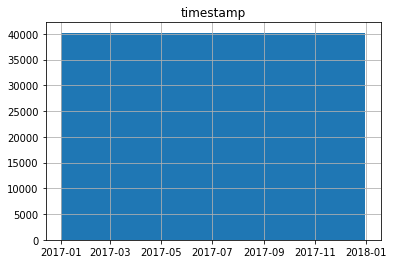

In [13]:
#Histogram of timestamps, seems like there's a big hole...
import matplotlib.pyplot as plt
%matplotlib inline
df.hist(column='timestamp')

array([[<AxesSubplot:title={'center':'temperature'}>]], dtype=object)

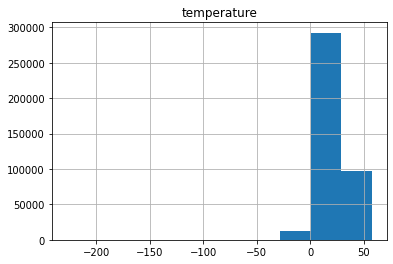

In [14]:
#And temperature...
df.hist(column='temperature')

In [15]:
#Seems like we have a wild outlier... can we get it and get rid of it?
df.loc[df['temperature']<-50]

,timestamp,temperature
163499,2017-09-18 10:00:00,-227.144909


array([[<AxesSubplot:title={'center':'temperature'}>]], dtype=object)

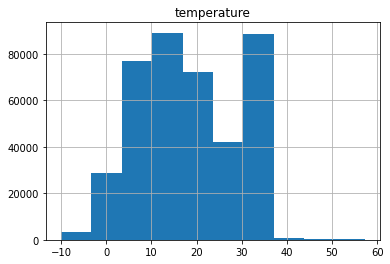

In [16]:
#Looks better!
df = df.drop(163499)
df.hist(column='temperature')

In [17]:
#Any duplicates?
df[df.duplicated()].sum()

temperature    810.628033
dtype: float64

In [18]:
#lOTS!
df[df.duplicated()]

,timestamp,temperature
29488,2017-05-17 19:00:00,34.768500
161208,2017-06-14 23:00:00,34.774333
297178,2017-01-01 17:00:00,-1.332000
297233,2017-01-01 21:35:00,-1.727600
297564,2017-01-03 01:10:00,0.407800
...,...,...
396266,2017-12-11 18:20:00,6.677800
397151,2017-12-14 20:05:00,4.045800
397512,2017-12-16 02:10:00,4.334000
397513,2017-12-16 02:15:00,4.334000


In [19]:
#So we have data values from what seem to be a number of different sensors at the same times, let's combine them
#into a min-max-avg for each timestamp
timestamps = df['timestamp'].unique()
newdf = pd.DataFrame(columns = ['timestamp', 'min', 'max', 'mean'])
for datetime in timestamps:
    #grab temperatures based on the unique timestamp
    temps = df[df.timestamp == datetime]
    mintmp = temps['temperature'].min()
    maxtmp = temps['temperature'].max()
    meantmp = temps['temperature'].mean()
    #append to the new dataframe
    newdf = newdf.append({'timestamp': datetime, 'min': mintmp, 'max': maxtmp, 'mean': meantmp}, ignore_index = True)
    
newdf.head()

KeyboardInterrupt: 

In [20]:
#Save the new dataframe to a csv for later use
#newdf.to_csv('new_temp_2017.csv')
newdf = pd.read_csv('Beehive Metrics Dataset/new_temp_2017.csv')

array([[<AxesSubplot:title={'center':'mean'}>]], dtype=object)

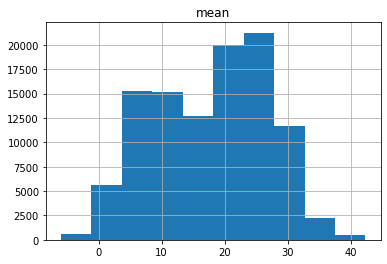

In [21]:
#Let's see some histograms of the new dataframe
newdf.hist(column='mean')

array([[<AxesSubplot:title={'center':'max'}>]], dtype=object)

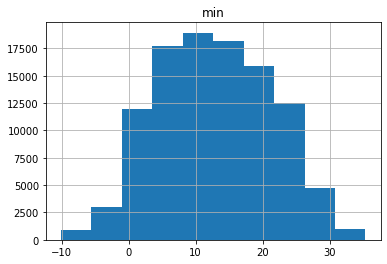

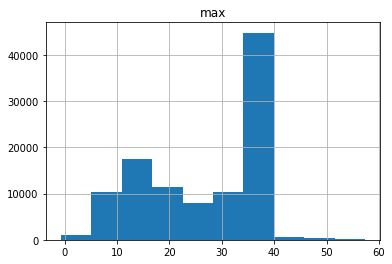

In [22]:
newdf.hist(column='min')
newdf.hist(column='max')

In [23]:
#Show mean, standard dev, min, max, and IQRs after dropping rows
newdf.describe()

,min,max,mean
count,104821.000000,104821.000000,104821.000000
mean,12.802953,25.886408,17.824496
std,8.472256,10.502566,9.016849
min,-10.072000,-0.740800,-5.983067
25%,6.006200,15.736000,9.939600
50%,12.606000,31.880000,19.113333
75%,19.520000,34.934000,25.272000
max,35.320000,57.362000,42.362667


In [24]:
#Get median, mode, variance
print("median", df['temperature'].median())
print("mode", mode(df['temperature']).mode[0])
print("variance", df['temperature'].var())

median 17.17966666666666
mode 35.044000000000004
variance 125.37678567839768


<AxesSubplot:xlabel='timestamp'>

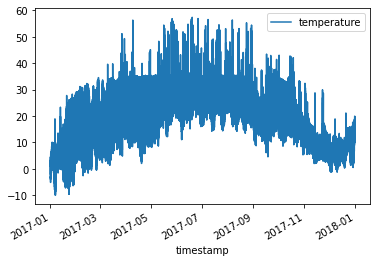

In [25]:
df.plot(x='timestamp', y='temperature')